Code for Hawks Process function tranlsated from matlab from chiangwe's HawkPR  repository

## Python version

In [3]:
import ipykernel 
ipykernel.__version__

'6.25.0'

In [2]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


*Input variables*
*(CSV Files)*

Each has 2824 counties identified by an FIPS code
1.   **Report** ;
rows: 2824 x 6 (6 locations for cases);
cols: 4 + 297 (dates) [15/02/20 - 07/12/20];
records number of cases

2. **Mobility**;
rows: 2824 (counties);
cols: 3 + 297 (dates);
records amount of mobility

3.   **Demography**;
rows: 2824;
cols: 9;
records demographic identifiers of each county




In [38]:
import numpy as np
import pandas as pd
import warnings
import time
import scipy
import random
import scipy.stats as stats
import scipy.sparse as sparse
from scipy.stats import weibull_min, poisson
from scipy.optimize import curve_fit, minimize
from scipy.sparse import csc_matrix, eye
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
from sklearn.linear_model import PoissonRegressor
from scipy import sparse
import matplotlib.pyplot as plt
#from google.colab import drive
#drive.mount('/content/drive')

In [39]:
#scale of weibull
Alpha = 0
#shape of weibull
Beta = 0

# num of maximum iterations for EM algortihm in case convergence not reached
EMitr = 20

#additional days to be predicted by trained hawks process model
DaysPred = 6

#mobility shift parameter: ???
Delta = 3

SimTimes = 6

#to_csv function will automatically create a csv file with this path
OutputPath_pred = '/content/drive/My Drive/HawkPR_data_sim/Output.csv'
OutputPath_mdl = r"C:\Users\dipiy\OneDrive\Documents\GitHub\CausalSTPP\TestData"

In [40]:
# Path to your CSV file in Google Drive
InputPath_demography = r"C:\Users\dipiy\OneDrive\Documents\GitHub\CausalSTPP\TestData\Demography_Test.csv"
InputPath_report = r"C:\Users\dipiy\OneDrive\Documents\GitHub\CausalSTPP\TestData\Report_Test2.csv"
InputPath_mobility = r"C:\Users\dipiy\OneDrive\Documents\GitHub\CausalSTPP\TestData\Mobility_Test.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(InputPath_mobility)

#print(df.head())
num_rows, num_columns = df.shape
print(f'Number of rows: {num_rows}')
print(f'Number of columns: {num_columns}')

Number of rows: 120
Number of columns: 21


In [7]:
def covid_tr_ext_j(covid_tr, n_day_tr):
    #extends covid_tr vertically
    return np.repeat(covid_tr, n_day_tr, axis=0)

def covid_tr_ext_i(covid_tr, n_day_tr, n_cty):
    #extends covid_tr horizontally
    return np.tile(covid_tr.T, (1, n_day_tr)).T

In [5]:
def updatep(t, p, q, K0, alpha, beta, mu):
    N = t.shape[0]
    lam = np.zeros(N)

    for i in range(N):
        for j in range(i):
            ## Calculate p(i, j), i > j stands for the probability of ONE SINGLE event at day i triggered by "ALL" events at day j
            p[i, j] = K0[j] * weibull_min.pdf(i - j, beta, scale=alpha) * t[j]

            ## Calculate q(i, j), i > j stands for the probability of ONE SINGLE event at day i triggered by "ONE SINGLE" event at day j
            # note that (t(j)>0) is to see whether there is an event in day j or not
            # if so we calculate single event at day j. if not, it remaind zero.
            q[i, j] = K0[j] * weibull_min.pdf(i - j, beta, scale=alpha) * (t[j] > 0)

        ## Probability ii is a background event proportional to mu background rate
        p[i, i] = mu
        q[i, i] = mu

        ## Save intensity at each event for analysis
        lam[i] = np.sum(p[i, :i+1])

        ## Normalize probabilities
        # note that p will sum to 1 since all events at day j are considered, q won't
        p[i, :i+1] = p[i, :i+1] / lam[i]
        q[i, :i+1] = q[i, :i+1] / lam[i]

        if np.isnan(p).sum() > 0:
            print("temp")

    return p, q, lam

In [41]:
from scipy.interpolate import RegularGridInterpolator

def plot2dFunc(kernel, timeList, countyList, x_label='X-axis', y_label='Y-axis', title='Heatmap', ngrid=100):
    """
    Generates a continuous gradient heatmap from a 2D kernel with grid lines and custom labels.

    Parameters:
    kernel (2D np.array): The input 2D array representing the function over 2 dimensions.
    should be of shape n_cty x n_day
    timeList (list of str): Labels for the x-axis (time markers).
    countyList (list of str): Labels for the y-axis (county markers).
    x_label (str): Label for the X-axis.
    y_label (str): Label for the Y-axis.
    title (str): The title of the heatmap.
    ngrid (int): Resolution of the final image (ngrid x ngrid).

    Returns:
    None: Displays the heatmap.
    """
    # Get the size of the kernel
    x = np.linspace(0, 1, kernel.shape[1])
    y = np.linspace(0, 1, kernel.shape[0])
    
    # Interpolation function using RegularGridInterpolator with linear interpolation
    interp_func = RegularGridInterpolator((y, x), kernel, method='cubic')
    
    # Generate new grid with higher resolution
    x_new = np.linspace(0, 1, ngrid)
    y_new = np.linspace(0, 1, ngrid)
    x_new_grid, y_new_grid = np.meshgrid(x_new, y_new)
    
    # Interpolate the values on the new grid
    points = np.array([y_new_grid.ravel(), x_new_grid.ravel()]).T
    kernel_interp = interp_func(points).reshape((ngrid, ngrid))

    # Plotting the heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(kernel_interp, extent=[0, 1, 0, 1], origin='lower', cmap='viridis', aspect='auto')
    plt.colorbar()
    
    # Set custom labels for x and y axes
    plt.xticks(np.linspace(0, 1, len(timeList)), timeList)
    plt.yticks(np.linspace(0, 1, len(countyList)), countyList)
    
    # Add grid lines
    plt.grid(axis='x', color='white', linestyle='--', linewidth=0.5)
    plt.grid(axis='y', color='red', linestyle='--', linewidth=0.5)

    # Add axis labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
    # Show the heatmap
    plt.show()


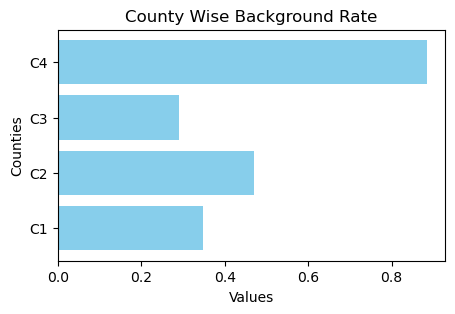

In [43]:
def plotmu(mus, n_cty, KeyList):
    '''
    Function to plot background rate after or midst of model fitting.
    '''
    if len(mus) != n_cty or len(KeyList) != n_cty:
        raise ValueError("Length of mus and KeyList must be equal to n_cty.")

    # horizontal bar chart
    plt.figure(figsize=(5, 3))  #ptional: Adjust the figure size to fit your data
    plt.barh(KeyList, mus.flatten(), color='skyblue')

    plt.xlabel('Values')
    plt.ylabel('Counties')
    plt.title('County Wise Background Rate')
    plt.show()


In [50]:
def snipDataset(InputPath_Data, DateSnip, CountySnip, rowheaders): 
    '''Code will return three arrays: 1 for the data with only values
    also sets NaN values to zero 
    one of the columnKeyList, one of the rowKeyList
    Parameters:
    InputPath_Data: sepcifies the input path to dataset
    Datesnip: specifies number of days to crop: columns
    CountySnip: specifies number of counties to crop: rows 
    rowheaders: number of types of rowheaders (eg: county name, countyID, State)
    colheaders: number of types of rowheaders (eg: dates) '''
    Data = pd.read_csv(InputPath_Data)
    if DateSnip == None:
        Data_Values = Data.iloc[:CountySnip, rowheaders:].values
        Data_Values[np.isnan(Data_Values)] = 0
        rowKeyList = Data.iloc[:CountySnip, :rowheaders]
        colKeyList = Data.columns[rowheaders:]
    else: 
        Data_Values = Data.iloc[:CountySnip, rowheaders: rowheaders+ DateSnip].values
        Data_Values[np.isnan(Data_Values)] = 0
        rowKeyList = Data.iloc[:CountySnip, :rowheaders]
        colKeyList = Data.columns[rowheaders:rowheaders+DateSnip]
        
    
    
    return Data_Values, rowKeyList, colKeyList 

InputPath_demography = r"C:\Users\dipiy\OneDrive\Documents\GitHub\CausalSTPP\TestData\Demography_Test.csv"
InputPath_report = r"C:\Users\dipiy\OneDrive\Documents\GitHub\CausalSTPP\TestData\Report_Test2.csv"
InputPath_mobility = r"C:\Users\dipiy\OneDrive\Documents\GitHub\CausalSTPP\TestData\Mobility_Test.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(InputPath_mobility)

#print(df.head())
num_rows, num_columns = df.shape
print(f'Number of rows: {num_rows}')
print(f'Number of columns: {num_columns}')

Data, rowHeaders, colHeaders = snipDataset(InputPath_report, 4, 5, 3)
print(Data)
print(rowHeaders)
print(colHeaders)

    

Number of rows: 120
Number of columns: 21
[[28. 32. 40. 53.]
 [22. 27. 40. 51.]
 [ 1.  2.  8.  8.]
 [ 3.  3.  3.  4.]
 [ 7.  9. 10. 11.]]
    FIPS       State       County
0   6037  California  Los Angeles
1  17031    Illinois         Cook
2  12086     Florida   Miami-Dade
3   4013     Arizona     Maricopa
4  48201       Texas       Harris
Index(['x2020-02-15', 'x2020-02-16', 'x2020-02-17', 'x2020-02-18'], dtype='object')


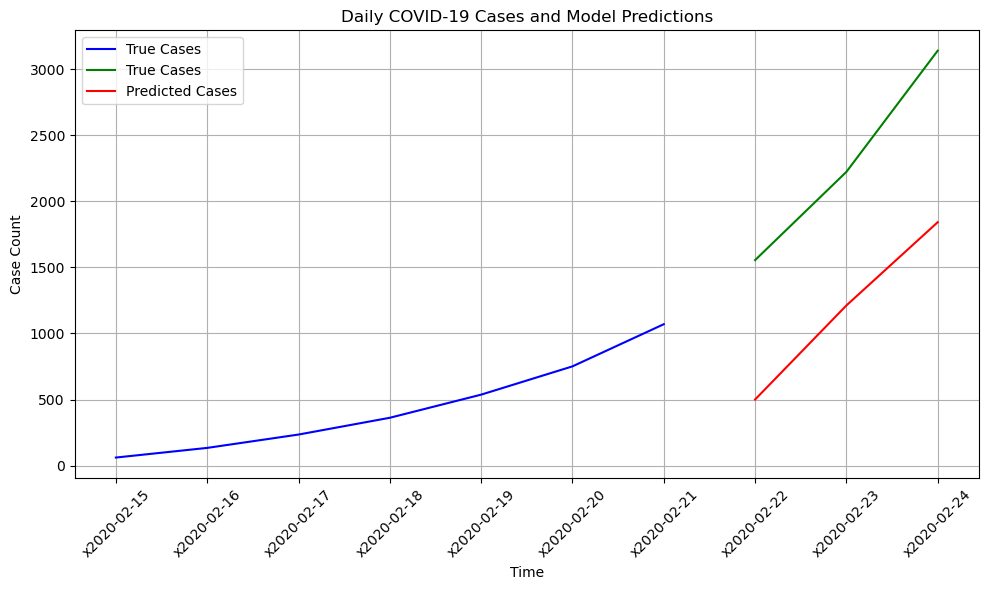

In [55]:
def plot_covid_predictions(DaysPred, n_day_tr, covid_og, pred_cases, DatesList, compare):
    # Error checking
    if covid_og.shape[1] != (n_day_tr +DaysPred):
        raise ValueError(f"covid_og should have {n_day_tr +DaysPred} days, but got {covid_og.shape[1]} days.")
    
    if len(pred_cases) != DaysPred:
        raise ValueError(f"pred_cases should have {DaysPred} days, but got {len(pred_cases)} days.")
    
    if len(DatesList) != (n_day_tr +DaysPred):
        raise ValueError(f"DatesList should have {n_day_tr +DaysPred} entries, but got {len(DatesList)} entries.")
    
    # Sum cases along axis=0 to get daily cases across all counties
    daily_cases = np.cumsum(covid_og.sum(axis=0))
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    
    # Plot the original daily cases used for training
    plt.plot(DatesList[:n_day_tr], daily_cases[:n_day_tr], label="True Cases", color="blue")
    
    # If compare is True, highlight the last DaysPred days and plot predicted cases
    if compare:
        plt.plot(DatesList[-DaysPred:], daily_cases[-DaysPred:], label="True Cases", color="green")
        plt.plot(DatesList[-DaysPred:], np.cumsum(pred_cases), label="Predicted Cases", color="red")
    else: 
        plt.plot(DatesList[-DaysPred:], np.cumsum(pred_cases), label="Predicted Cases", color="red")        
    
    # Labeling the graph
    plt.xlabel("Time")
    plt.ylabel("Case Count")
    plt.title("Daily COVID-19 Cases and Model Predictions")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
Data, rowHeaders, colHeaders = snipDataset(InputPath_report, DateSnip=10, CountySnip=5, rowheaders=3)
ypred = [500, 712, 630]
plot_covid_predictions(DaysPred=3, n_day_tr=7, covid_og=Data, pred_cases=ypred, DatesList=colHeaders, compare=True)
# plot_covid_predictions(DaysPred=7, n_day=100, covid_og=np.random.rand(10, 100), pred_cases=np.random.rand(7), DatesList=pd.date_range(start='1/1/2020', periods=100), compare=True)


code uses a weibull distribution to model inter infection times. the parameters are updated within the code according to the expectation maximization algorithm.

In [65]:
def HawkPR(InputPath_report, InputPath_mobility, InputPath_demography, Delta, Alpha, Beta, EMitr, DaysPred, SimTimes, OutputPath_mdl, OutputPath_pred):
#def HawkPR(Report, Mobility, Demography, Delta, Alpha, Beta, EMitr, DaysPred, SimTimes, OutputPath_mdl, OutputPath_pred):
    warnings.filterwarnings('ignore')

    # Read in parameters
    if Alpha == '' and Beta == '':
        print('No shape and scale parameter for Weibull distribution provided. Use MLE to infer alpha and beta ... ')
        alphaScale_in = 0
        betaShape_in = 0
    else:
        alphaScale_in = float(Alpha)
        betaShape_in = float(Beta)

    if Delta == '':
        print('No shift parameter for mobility provided. It will set to zero ... ')
        mobiShift_in = 0
    else:
        mobiShift_in = int(Delta)

    # Read-in COVID data
    covid, Report_KeyList, Report_DateList = snipDataset(InputPath_report, 16, 20, 3)
    covid = np.hstack([np.zeros((covid.shape[0], 1)), np.diff(covid, axis=1)])
    covid[covid <= 0] = 0

    # Read-in mobility,
    mob_val, mob_head, Mobi_Date_list = snipDataset(InputPath_mobility, DateSnip=16, CountySnip=120, rowheaders=4)
    for _ in range(mobiShift_in):
        mob_val = np.hstack([np.mean(mob_val[:, :7], axis=1, keepdims=True), mob_val])
    Mobi_Type_list = mob_head.iloc[:6, 3].values
    Mobi_Key_list = mob_head.iloc[::6, :3].values

    # Read-in demographic
    Demo_val, Demo_Key_list, Demo_Type_list = snipDataset(InputPath_demography, DateSnip=None, CountySnip=20, rowheaders=1)

    n_cty, n_day = covid.shape
    n_mobitype = mob_val.shape[0] // n_cty

    print(f'There are {n_cty} counties, {n_mobitype} types of Mobility indices, and {n_day} days in the COVID reports.')

    # Train & Test Split
    #assumption is that mob and demo data is available for n_day+DaysPred days but report only available for n_day = n_tr
    n_tr = covid.shape[1] # - DaysPred #this way, covid has same length as mobi and demo and only the first n_day_tr cases are used for training, rest DaysPred cases used for comparison 
    mob_tr = mob_val[:, :n_tr]
    mob_te = mob_val[:, n_tr:n_tr+DaysPred]

    # Normalization
    mob_tr_reshape = mob_tr.reshape(n_mobitype,-1).T
    mob_te_reshape = mob_te.reshape(n_mobitype, -1).T

    Demo_val_in = Demo_val
    Demo_val_tr = np.tile(Demo_val_in, (n_tr, 1))
    Demo_val_te = np.tile(Demo_val_in, (DaysPred, 1))

    covid_tr = covid #covid.iloc[:, :n_tr] #only n_tr days of cases used for training

    Covar_tr = np.hstack([mob_tr_reshape, Demo_val_tr])
    Covar_te = np.hstack([mob_te_reshape, Demo_val_te])

    Covar_tr_mean = np.mean(Covar_tr, axis=0)
    Covar_tr_std = np.std(Covar_tr, axis=0)

    Covar_tr = (Covar_tr - Covar_tr_mean) / Covar_tr_std
    Covar_te = (Covar_te - Covar_tr_mean) / Covar_tr_std

    # Get Variable names
    #clean up variable names
    VarNamesOld = np.concatenate([Mobi_Type_list, Demo_Type_list.T, ['Qprob']])
    VarNames = [name.replace(' & ', '_').replace(' ', '_').lstrip('_') for name in VarNamesOld]

    # Define Parameters
    n_day_tr = n_day
    dry_correct = 2

    emiter = EMitr
    break_diff = 1e-3
    day_for_tr = min(n_day_tr - dry_correct, mob_tr.shape[1])

    # Initialize Inferred Parameters
    if (alphaScale_in == 0) and (betaShape_in == 0):
        alpha = 2
        beta = 2
    else:
        alpha = alphaScale_in
        beta = betaShape_in

    # Initial Weibull values
    wbl_val = np.tile(np.tril(weibull_min.pdf(np.arange(1, n_day_tr+1)[:,None] - np.arange(1, n_day_tr+1), c=beta, loc=0, scale=alpha)), (n_cty, 1))
    #wbl_val is a n_day_tr square lower triangular matrix, tiled n-cty times vertically. it's only lower trianlge because it's only when i<j

    # K0 reproduction number, a function of time and mobility.
    # K0 is a n_county * n_day by n_day matrix.
    K0 = np.ones((n_cty, n_day_tr))
    K0_ext_j = np.repeat(K0, n_day_tr, axis=0)

    # q is a n_county * n_day by n_day matrix.
    q = sparse.lil_matrix((n_cty * n_day_tr, n_day_tr))

    # Mu is the background rate
    mus = 0.5 * np.ones(n_cty*n_day_tr)
    mus = mus.reshape(n_cty , n_day_tr)

    # lam is the event intensity
    lam = np.zeros((n_cty, n_day_tr))

    # EM iteration
    alpha_delta = []
    alpha_prev = []
    beta_delta = []
    beta_prev = []
    mus_delta = []
    mus_prev = []
    K0_delta = []
    K0_prev = []
    theta_delta = []
    theta_prev = []

    for itr in range(emiter):
        start_time = time.time()

        # E-step
        '''
        Expectation step
        - given the parameters 0, alpha, beta and mus_c estimated from last iteration
        - estimate latent variables p_c(i,j) for each county
        - calculated using formula:

        p_c(i,j) = R(x_c^t_j-delta, 0) w(t_i - t_j |alpha,beta) / lam_c(t_i)
        {probability that injection i causes j}

        p_c(i,i) = mus_c/ lam_c(t_i)
        {probability that infection is imported}

        '''
        #creating probability matrix
        q = K0_ext_j * wbl_val * (covid_tr_ext_j(covid_tr, n_day_tr) > 0)
        #the diagonal values in the untiled version of this are empty 
        
        #mu identity matrix   
        #mus will change into a fully n_cty by n_day function. how will we get p_ii from it 
        #we can take average mus across the county and then turn that n_cty,1 matrix into eye_mu 
        #or we can leave it as mus here instead of eye_mu             
        eye_mu = np.tile(np.identity(n_day_tr), (n_cty,1)) * np.tile(mus, (n_day_tr,1))
        
        lam = np.sum(q * covid_tr_ext_j(covid_tr, n_day_tr) + eye_mu, axis=1)
        lam = lam.reshape(lam.shape[0],1)
        lam_eq_zero = lam == 0
        
        #p_c(i,j) = R_c(x^tj . 0) x w(ti - tj|α,β)
        q = np.divide(q,lam)
        q[lam_eq_zero.flatten()] = 0
        lam = lam.reshape(n_day_tr, n_cty).T
        
        #p_c(i,i) = μ_c 
        p_ii = np.divide(mus,lam)
        #p_ii = np.divide(eye_mu,lam)
        lam_eq2_zero = lam == 0
        p_ii[lam_eq2_zero] =0

        # M-step
        '''
        Maximisation step

        maximise the data log likelihood wrt model parameters, done in three different opimisation problems
        1) coefficient 0 from poisson regression
        2) maximum likelihood estimation for shape and scale parameters (alpha and beta)
        3) background rate mu determined analytically
        '''
        # Calculate Q, which stands for the average number (observed) of children generated by a SINGLE event j
        # Note that the last "dry_correct" days of Q will be accurate, since we haven't observed their children yet
        Q = np.reshape(q * covid_tr_ext_i(covid_tr, n_day_tr, n_cty), (n_day_tr, n_day_tr * n_cty))
        Q = np.reshape(np.sum(Q, axis=0), (n_cty, n_day_tr))
        
        # Estimate K0 and Coefficients for Poisson regression
        glm_tr = np.nan_to_num(Covar_tr[:n_cty*day_for_tr, :])
        #training data: covar is of shape with n_cty*n_day-tr rows, so dep variable should be a long array of that length
        glm_y = np.nan_to_num(Q[:, :day_for_tr].reshape(-1,1))
        print(f'shape of glm_y in K0 model: {glm_y.shape}')

        glm_tr = sm.add_constant(glm_tr)

        freqs = covid_tr[: , :day_for_tr].reshape(-1,1)
        freqs = freqs.flatten()
        np.nan_to_num(freqs)
        freqs[freqs < 0] = 0 #freq cannot be negative
        if not np.all(np.isfinite(freqs)):
            raise ValueError("Invalid values detected in `freqs`. Check your data preprocessing.")

        print(f'shape of freqs: {freqs.shape}')

        family = Poisson()
        # Define the GLM model with cleaned data and specify missing='drop'
        model = sm.GLM(glm_y, glm_tr, family=family, freq_weights=freqs, missing='drop')
        print(model)

        # Fit the model
        result = model.fit(maxiter=300)
        print(result.summary())
        
        # M-step Part1)
        ypred = result.predict(sm.add_constant(Covar_tr))

        # Reshape ypred to match the original dimensions
        K0 = np.reshape(ypred, (n_cty, n_day_tr))

        # Bound K0
        K0 = scipy.signal.savgol_filter(K0, window_length=5, polyorder=2)
        K0_ext_j = np.repeat(K0, n_day_tr, axis=0)

        # M-step Part 3)
        # Estimate mu, the background rate
        
        #freqs will be the same 
        #Q, or dependent variable will now be p_(i,i), which is basically mu only, multiplied with frequencies
        #glm_tr = same 
        glm_y = np.nan_to_num(p_ii[:,:day_for_tr].reshape(-1,1))
        print(f'shape of glm_y in mu model: {glm_y.shape}')        
        
        model_mu = sm.GLM(glm_y, glm_tr, family=sm.families.Poisson(), freq_weights=freqs, missing='drop')
        result_mu = model_mu.fit(maxiter=200)
        print(result_mu.summary())
        mus = result_mu.predict(sm.add_constant(Covar_tr)).reshape(n_cty, n_day_tr)
        #plot2dFunc(kernel=mus, timeList=Report_DateList, countyList=Report_KeyList[0])
    
        # M-step Part 2)
        # Weibull fitting
        if (alphaScale_in == 0) and (betaShape_in == 0):
            # Create the observation matrix
            obs = np.tril(np.arange(1, day_for_tr + 1).reshape(-1, 1) - np.arange(1, day_for_tr + 1), -1)

            # Calculate the frequency
            freq = covid_tr_ext_j(covid_tr, n_day_tr) * covid_tr_ext_i(covid_tr, n_day_tr, n_cty) * q
            freq = freq.toarray() if isinstance(freq, sparse.csr_matrix) else freq
            freq = np.sum(np.transpose(freq.reshape(n_day_tr, n_cty, n_day_tr), (0, 2, 1)), axis=2)
            freq = freq[:day_for_tr, :day_for_tr]

            # Find indices where both obs and freq are positive
            Ind_ret = np.where((obs > 0) & (freq > 0))
            obs = obs[Ind_ret]
            freq = freq[Ind_ret]
            
            # Equivalent to: [coef,~] = wblfit(obs,[],[],freq); there is no py function to fit a weibull distribution need to MLE manually
            
            def neg_log_likelihood(params, obs, freq):
                alpha, beta = params
                # Weibull PDF for the observed values
                pdf_vals = weibull_min.pdf(obs, c=beta, scale=alpha)
                # Log-likelihood weighted by freq
                log_likelihood = np.sum(freq * np.log(pdf_vals))
                # Return negative log-likelihood
                return -log_likelihood

            # Initial guess for alpha and beta
            initial_guess = [1.0, 1.0]
            # Minimize the negative log-likelihood
            optimum = minimize(neg_log_likelihood, initial_guess, args=(obs, freq), method='L-BFGS-B', bounds=[(1e-5, None), (1e-5, None)])

            # Extracting the scale (alpha) and shape (beta) parameters
            alpha, beta = optimum.x

            # Now you can use these parameters as needed
            print(f"Fitted alpha (scale): {alpha}")
            print(f"Fitted beta (shape): {beta}")

            # Creating wbl_val
            wbl_val = np.tile(np.tril(weibull_min.pdf(np.arange(1, n_day_tr+1)[:, None] - np.arange(1, n_day_tr+1), c=beta, scale=alpha)), (n_cty, 1))

        # Convergence check
        if itr == 0:
            #save the first value
            alpha_prev = alpha
            beta_prev = beta
            mus_prev = mus
            K0_prev = K0
            theta_prev = result.params
        else:
            #calculate the RMSR
            alpha_delta = np.hstack((alpha_delta, np.sqrt((alpha - alpha_prev)**2)))
            beta_delta = np.hstack((beta_delta, np.sqrt((beta - beta_prev)**2)))
            mus_delta = np.hstack((mus_delta, np.sqrt(np.mean((mus_prev - mus)**2))))
            K0_delta = np.hstack((K0_delta, np.sqrt(np.mean((K0_prev - K0)**2))))
            theta_delta = np.hstack((theta_delta, np.sqrt((np.sum((theta_prev - np.array(result.params))**2)) / len(np.array(result.params)))))

            #save the current
            alpha_prev = alpha
            beta_prev = beta
            mus_prev = mus
            K0_prev = K0
            theta_prev = np.array(result.params)
            

        # Early Stop
        if itr > 5:
          # Check the last 5 elements
          rule = (np.all(alpha_delta[-5:] < break_diff) and 
                  np.all(beta_delta[-5:] < break_diff) and 
                  np.all(mus_delta[-5:] < break_diff) and 
                  np.all(K0_delta[-5:] < break_diff) and 
                  np.all(theta_delta[-5:] < break_diff))
          
          if rule:
              print("Convergence Criterion Met. Breaking out of EM iteration...")
              break

        elapsed_time = time.time() - start_time
        print(f"ITR: Iteration {itr+1}, Elapsed time: {elapsed_time:.2f} seconds ------------------------------------------------")

    if itr == emiter - 1:
        print('Reached maximum EM iteration.')


    print(f"---- E M Algorithm Completed -----------------------------------------------------------------------------------")
    # Start Simulation
    np.savez(OutputPath_mdl, mus=mus, alpha=alpha, beta=beta, K0=K0, VarNames=VarNames, alpha_delta=alpha_delta, beta_delta=beta_delta, mus_delta=mus_delta, K0_delta=K0_delta, theta_delta=theta_delta)
    loaded_data = np.load(OutputPath_mdl + '.npz')

    # Get K0
    print(f'shape of Covar_tr: {Covar_tr.shape}')
    print(f'shape of Covar_te: {Covar_te.shape}')
    Covar_all = np.vstack((Covar_tr, Covar_te))
    n_day = n_day_tr + DaysPred
    T_sim = n_day
    Tlow = T_sim - DaysPred

    # Predict
    ypred = result.predict(sm.add_constant(Covar_all))
    fK0 = ypred.reshape(n_cty, n_day)
    # Make fK0 stable
    fK0[fK0 > 4] = 4
    
    mu_pred = result_mu.predict(sm.add_constant(Covar_all))
    fmu = mu_pred.reshape(n_cty, n_day)
    #exponentiate mu?? just basic exp or just where it's negative 
    # fmu = np.exp(fmu)
    # fmu[fmu<0]=np.exp(fmu[fmu<0])

    # Simulation results
    sim = np.zeros((n_cty, T_sim, SimTimes))

    # Simulate offsprings
    n_per_batch = 10**2
    K0_sim = fK0[:, Tlow:]
    mus_sim = fmu[:, Tlow:]
    

    for itr in range(SimTimes):
        np.random.seed(itr)

        # Calculate base rate
        base = np.zeros((n_cty, DaysPred))
        n_exh = np.zeros((n_cty, DaysPred))

        t_stamps = np.arange(Tlow + 1, T_sim + 1)[:, None] - np.arange(1, Tlow + 1)  
        intense = (np.tile(weibull_min.pdf(t_stamps, beta, scale=alpha), (n_cty, 1, 1)) * np.tile(fK0[:, :Tlow].reshape(n_cty, 1, Tlow), (1, DaysPred, 1)) *
        np.tile(covid_tr[:, :Tlow].reshape(n_cty, 1, Tlow), (1, DaysPred, 1)))
        
        base = np.sum(intense, axis=2) + mus_sim
        n_exh = np.random.poisson(base)

        for itr_cty in range(int(np.ceil(n_cty * 0.5))):
            for itr_d in range(DaysPred):
                max_d = DaysPred - itr_d

                # Sample first
                if n_exh[itr_cty, itr_d] > n_per_batch:
                    n_batch = n_exh[itr_cty, itr_d] // n_per_batch
                    cand = np.random.poisson(K0_sim[itr_cty, itr_d], size=n_per_batch)
                    n_mod = n_exh[itr_cty, itr_d] % n_per_batch
                    n_offs = np.sum(cand) * n_batch + np.sum(np.random.poisson(K0_sim[itr_cty, itr_d], size=n_mod))
                else:
                    n_offs = np.sum(np.random.poisson(K0_sim[itr_cty, itr_d], size=n_exh[itr_cty, itr_d]))

                if n_offs > n_per_batch:
                    n_batch = n_offs // n_per_batch
                    n_mod = n_offs % n_per_batch

                    sim_cand_wbl = np.ceil(weibull_min.rvs(alpha, scale=beta, size=n_per_batch))
                    sim_cand_wbl = sim_cand_wbl[sim_cand_wbl <= max_d]
                    sim_cand_wbl = np.histogram(sim_cand_wbl, bins=np.arange(1, max_d + 2))[0]

                    t_delta = np.ceil(weibull_min.rvs(alpha, scale=beta, size=n_mod))
                    t_delta = t_delta[t_delta <= max_d]
                    nt = np.histogram(t_delta, bins=np.arange(1, max_d + 2))[0] + sim_cand_wbl * n_batch
                else:
                    t_delta = np.ceil(weibull_min.rvs(alpha, scale=beta, size=n_offs))
                    t_delta = t_delta[t_delta <= max_d]
                    nt = np.histogram(t_delta, bins=np.arange(1, max_d + 2))[0]


        sim[:, :, itr] = np.concatenate((covid_tr, n_exh), axis=1)

    sim_out = sim[:, -DaysPred:, :]

    # Format the output
    sim_mean = np.mean(sim_out, axis=2)
    print (sim_mean)
    #Date_pred = pd.date_range(start=NYT_Date_list[-1], periods=DaysPred, freq='D').strftime('%Y_%m_%d').to_list()
    #table_out = pd.DataFrame(sim_mean, columns=Date_pred)
    #table_out = pd.concat([NYT.iloc[:, :3], table_out], axis=1)

    #table_out.to_csv(OutputPath_pred, index=False)

In [66]:
HawkPR(InputPath_report, InputPath_mobility, InputPath_demography, Delta, Alpha, Beta, EMitr, DaysPred, SimTimes, OutputPath_mdl, OutputPath_pred)

There are 20 counties, 6 types of Mobility indices, and 10 days in the COVID reports.
shape of glm_y in K0 model: (160, 1)
shape of freqs: (160,)
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  160
Model:                            GLM   Df Residuals:                     1075
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3203.4
Date:                Fri, 06 Sep 2024   Deviance:                       5275.1
Time:                        02:06:02   Pearson chi2:                 9.53e+03
No. Iterations:                    12   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.0